# RNN Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re

# if you want to download the original file:
#df = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/50k_imdb_movie_reviews.csv')
# otherwise load local file
df = pd.read_csv('../Semana 3/shuffled_movie_data.csv')
df.tail()

Using TensorFlow backend.


,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


Let us shuffle the class labels.

In [2]:
import numpy as np

<br>
<br>

## Preprocessing Text Data

Se modifico la funcion tokenizer para que funcione de mejor forma con word2vect y asi acotar el resultado del vocabulario.

In [3]:
import numpy as np
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')
porter = PorterStemmer()

del stop[116]
del stop[116]
del stop[116]

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('[\W]+', ' ', text.lower()).replace('-', '')
    text = re.sub('[\d]+', ' ', text.lower()).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    return text

Let's give it at try:

In [4]:
tokenizer('123 This :) is a <a> test! :-)</br> . ')

['test']

## Learning (SciKit)

First, we define a generator that returns the document body and the corresponding class label:

In [5]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

To conform that the `stream_docs` function fetches the documents as intended, let us execute the following code snippet before we implement the `get_minibatch` function:

In [6]:
next(stream_docs(path='shuffled_movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

After we confirmed that our `stream_docs` functions works, we will now implement a `get_minibatch` function to fetch a specified number (`size`) of documents:

In [7]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return docs, y

Next, we will make use of the "hashing trick" through scikit-learns [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) to create a bag-of-words model of our documents. Details of the bag-of-words model for document classification can be found at  [Naive Bayes and Text Classification I - Introduction and Theory](http://arxiv.org/abs/1410.5329).

In [8]:
from sklearn.feature_extraction.text import HashingVectorizer
vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

# Exercise 1: define features based on word embeddings (pre-trained word2vec / Glove/Fastext emebddings can be used)
# Define suitable d dimension, and sequence length

# Obtener Nuevas Caracteristicas

En este caso usaremos la libreria de Gensim, word2vect para obtener los vectores de cada palabra, usando como base 100 valores en cada vector.

In [9]:
from gensim.models import Word2Vec

Para agilizar el proceso vamos a guardar en .csv los resultado obtenidos de aplicar la funcion de tokenizer sobre los review de la peliculas.

In [10]:
token_words = df['review'].apply(tokenizer)

In [11]:
print(token_words)

0        [teenager, martha, moxley, maggie, grace, move...
1        [ok, really, like, kris, kristofferson, usual,...
2        [spoiler, not, read, think, watching, movie, a...
3        [hi, people, seen, wonderful, movie, im, sure,...
4        [recently, bought, dvd, forgetting, much, hate...
5        [leave, braik, put, good, show, finally, zorak...
6        [nathan, detroit, frank, sinatra, manager, new...
7        [understand, crash, course, right, context, mu...
8        [impressed, chavez, stance, globalisation, som...
9        [movie, directed, renny, harlin, finnish, mira...
10       [lived, u, p, let, tell, foggyest, idea, heck,...
11       [hidden, frontier, notable, longest, running, ...
12       [ago, seen, sleuth, two, great, actors, michae...
13       [french, first, apparently, like, jerry, lewis...
14       [strange, movie, unlike, anything, made, west,...
15       [saw, movie, strength, single, positive, revie...
16       [great, philosophical, questions, purpose, lif.

Para obtener los vectores de palabras, enviamos todas las palabra del review proprocesadas a la función Word2Vec, al no especificar un size, este se establece en 100, y guardamos el modelo para utilizarlo posteriormente.

In [12]:
model = Word2Vec(token_words, min_count=1)

En el modelo final podemos ver que se tiene un vocabulario de 101487 palabras, esto representa una gran cantidad de entradas para la red neuronal.

In [13]:
print(model)

Word2Vec(vocab=101487, size=100, alpha=0.025)


Para realizar algunas pruebas podemos entrenar el modelo con la palabras y ver como obtenemos similaridad entre 2 vectores.

In [14]:
model.train(token_words, total_examples=len(token_words), epochs=10)

(57290522, 59944050)

Podemos ver obtenemos resultados semanticos de una palabra.

In [14]:
model.wv.most_similar(['teenager'])

[('grandmother', 0.745561957359314),
 ('daughter', 0.7072750926017761),
 ('sister', 0.6930811405181885),
 ('mom', 0.6729783415794373),
 ('roommate', 0.6648780107498169),
 ('envogue', 0.6546032428741455),
 ('brat', 0.6540639400482178),
 ('sabrina', 0.6520331501960754),
 ('spoiled', 0.6416873335838318),
 ('ager', 0.6410260200500488)]

# Exercise 1:

Define a nonlinear function for hidden layers.

Define a suitable loss function for binary classification

Implement the backpropagation algorithm for this structure

Do not use Keras / Tensorflow /PyTorch etc. libraries

Train the model using SGD


Obtenemos la mayor cantidad de palabras de los review para igualar todas las entradas a la red neuronal, obtenemos 1420 como maximo.

In [15]:
max_l = 0

for token in token_words.values:
    if max_l < len(token):
        max_l = len(token)
print(max_l)


1420


In [16]:
temp_arr = []

Definimos la funcion getMean() que obtendra la media de cada vector de palabras, de esta forma podemos obtener un solo valor y usarlo como entrada.

In [17]:
def getMean(list_v):
    sum_n = 0
    for num in list_v:
        sum_n += num
    return sum_n / len(list_v)

Para poder realizar operaciones con mayor velocidad convertimos los datos a numpy arrays y los formateamos de forma que podamos usarlo en la red Neuronal.

In [18]:
for token in token_words:
    temp = []
    for wd in token:
        temp.append(getMean(model.wv.__getitem__(wd)))
    for idx in range(max_l - len(token)):
        temp.append(0)
    temp_arr.append(temp)

In [19]:
arr_data = []
for idx, tmp in enumerate(temp_arr):
    t = []
    t.append(tmp)
    t.append([df['sentiment'][idx]])
    arr_data.append(t)

# Red Neuronal Recurrente

Despues de la definición de la red Neuronal, terminamos de dar formato a nuestro dataSet, de forma que podamos usarlo con nuestra red definida.

In [21]:
np_x = np.array(temp_arr)  

y = df['sentiment'].values
y_t = []
for idx, i in enumerate(y):
    y_t.append([y[idx]])
np_y = np.array(y_t) 


En np_x y np_y, guardamos los valores a ser entrenados, pero para realizar la validación separaremos esta data en 2 grupos con train_test_split, con el que usarmos el 80% de la data en entrenamiento y el otro 20% en la validación.

In [26]:
y_binary = to_categorical(df['sentiment'].values)
print(Y.shape)
print(y_binary.shape)
X_train, X_test, Y_train, Y_test = train_test_split(np_x,y_binary, test_size = 0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(50000,)
(50000, 2)
((33500, 1420), (33500, 2))
((16500, 1420), (16500, 2))


In [29]:
fatures = 2000

In [40]:
model = Sequential()
model.add(Embedding(fatures, 128,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1420, 128)         256000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 1420, 128)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 650,754
Trainable params: 650,754
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

batch_size = 24
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size)

Epoch 1/7
 2256/33500 [=>............................] - ETA: 3:05:58 - loss: 0.6936

In [ ]:
#Calc accuracy (validation) with 1500
val_size = 1500
X_validate = X_test[-val_size:]
Y_validate = Y_test[-val_size:]
X_test = X_test[:-val_size]
Y_test = Y_test[:-val_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

Obtenemos un accuracy de : 51% 

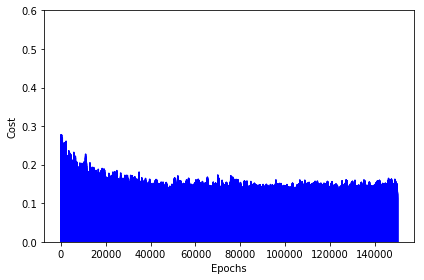

In [30]:
deltas = nn.get_deltas()
valores=[]
index=0
for arreglo in deltas:
    valores.append(arreglo[0] + arreglo[1])
    index=index+1
 
plt.plot(range(len(valores)), valores, color='b')
plt.ylim([0, 0.6])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Y en el grafico de como obtenemos los deltas que son los errores, vemos como baja de 0.3 a 0.2